In [1]:
import sys
import os
import shutil
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as sk_confusion_matrix # For easier plotting
import seaborn as sns # For heatmap

In [2]:
module_path = '/kaggle/input/dl-assignment-again/pytorch/default/1'
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from model import CaltechNetwork, contrastive_loss, custom_confusion_matrix, compute_metrics
from data_util import get_dataloaders # Adjusted to data_util.py

In [4]:
def plot_metrics(history, plots_dir, epochs):
    """Plots training and validation metrics and saves them."""
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
        print(f"Created '{plots_dir}' directory for plots.")

    epoch_range = range(1, epochs + 1)

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_range, history['train_loss'], label='Train Loss')
    plt.plot(epoch_range, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(plots_dir, 'loss_plot.png'))
    plt.close() # Close the figure to free memory

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_range, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epoch_range, history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig(os.path.join(plots_dir, 'accuracy_plot.png'))
    plt.close()

    # Plot Precision
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_range, history['train_precision'], label='Train Precision')
    plt.plot(epoch_range, history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.savefig(os.path.join(plots_dir, 'precision_plot.png'))
    plt.close()

    # Plot Recall
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_range, history['train_recall'], label='Train Recall')
    plt.plot(epoch_range, history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.savefig(os.path.join(plots_dir, 'recall_plot.png'))
    plt.close()

    # Plot F1-score
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_range, history['train_f1'], label='Train F1-score')
    plt.plot(epoch_range, history['val_f1'], label='Validation F1-score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-score')
    plt.title('Training and Validation F1-score')
    plt.legend()
    plt.savefig(os.path.join(plots_dir, 'f1_score_plot.png'))
    plt.close()

    print(f"Metric plots saved to {plots_dir}")

In [5]:
def plot_confusion_matrix(cm, class_names, title, save_path):
    """Plots a confusion matrix using seaborn heatmap."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.savefig(save_path)
    plt.close()
    print(f"Confusion matrix saved to {save_path}")

In [6]:
def train_model(dataset_path_source, epochs=20, lr=0.001, batch_size=32, threshold=0.5, use_local_copy=True, num_workers_loader=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    dataset_path_to_use = dataset_path_source
    if use_local_copy and not dataset_path_source.startswith('/kaggle/input/'):
        local_dataset_path = '/kaggle/working/caltech-101-local'
        print(f"Attempting to use a local copy of the dataset from {dataset_path_source} at {local_dataset_path}")
        if not os.path.exists(local_dataset_path) or not os.listdir(local_dataset_path):
            if os.path.exists(local_dataset_path):
                shutil.rmtree(local_dataset_path)
            print(f"Copying dataset from {dataset_path_source} to {local_dataset_path}...")
            shutil.copytree(dataset_path_source, local_dataset_path)
            print("Dataset copied locally.")
        else:
            print(f"Local dataset already exists at {local_dataset_path}. Using it.")
        dataset_path_to_use = local_dataset_path
    elif dataset_path_source.startswith('/kaggle/input/'):
        print(f"Using dataset directly from Kaggle input: {dataset_path_source}")
        dataset_path_to_use = dataset_path_source

    base_working_dir = '/kaggle/working/'
    weights_dir = os.path.join(base_working_dir, 'weights')
    plots_dir = os.path.join(base_working_dir, 'plots') # Directory for plots

    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir); print(f"Created '{weights_dir}' directory.")
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir); print(f"Created '{plots_dir}' directory for plots.")

    print("Initializing Dataloaders...")
    try:
        train_loader, val_loader, _ = get_dataloaders(dataset_path_to_use, batch_size, num_workers_val=num_workers_loader)
        print("Dataloaders initialized.")
        print(f"Train loader: {len(train_loader.dataset)} samples, {len(train_loader)} batches")
        print(f"Val loader: {len(val_loader.dataset)} samples, {len(val_loader)} batches")
    except Exception as e:
        print(f"Error during Dataloader initialization: {e}")
        return

    model = CaltechNetwork().to(device) # Assuming embedding_size is default 128 in CaltechNetwork
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

    best_val_loss = float('inf')

    # History tracking for plots
    history = {
        'train_loss': [], 'val_loss': [],
        'train_accuracy': [], 'val_accuracy': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': [],
        'train_f1': [], 'val_f1': [],
        'train_all_labels': [], 'train_all_preds': [], # For final confusion matrix
        'val_all_labels': [], 'val_all_preds': []     # For final confusion matrix
    }

    print(f"\nStarting training for {epochs} epochs...")
    for epoch in range(epochs):
        model.train()
        train_loss_sum = 0.0
        epoch_train_labels = []
        epoch_train_preds = []

        print(f"\n--- Epoch {epoch+1}/{epochs} ---")
        print("Training Phase:")
        for batch_idx, (img1, img2, labels) in enumerate(train_loader):
            if batch_idx % 20 == 0:
                 print(f"  Train Batch {batch_idx+1}/{len(train_loader)}")

            img1, img2, labels_dev = img1.to(device), img2.to(device), labels.to(device)

            optimizer.zero_grad()
            emb1, emb2 = model(img1, img2)
            loss = contrastive_loss(emb1, emb2, labels_dev)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * img1.size(0)

            with torch.no_grad():
                distance = torch.nn.functional.pairwise_distance(emb1, emb2)
                predictions = (distance < threshold).float()
                epoch_train_labels.extend(labels.cpu().numpy()) # Store original labels (CPU)
                epoch_train_preds.extend(predictions.cpu().numpy()) # Store predictions (CPU)

        # Calculate metrics from all collected labels and predictions for the epoch
        # Using your custom_confusion_matrix to get tp, tn, fp, fn for overall epoch metrics
        current_train_tp, current_train_tn, current_train_fp, current_train_fn = \
            custom_confusion_matrix(torch.tensor(epoch_train_labels), torch.tensor(epoch_train_preds))

        avg_train_loss = train_loss_sum / len(train_loader.dataset) if len(train_loader.dataset) > 0 else 0
        train_accuracy, train_precision, train_recall, train_f1 = compute_metrics(
            current_train_tp.item(), current_train_tn.item(), current_train_fp.item(), current_train_fn.item()
        )

        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)
        if epoch == epochs - 1: # Store all labels/preds only for the last epoch for final CM
            history['train_all_labels'] = epoch_train_labels
            history['train_all_preds'] = epoch_train_preds


        # Validation phase
        model.eval()
        val_loss_sum = 0.0
        epoch_val_labels = []
        epoch_val_preds = []

        print("Validation Phase:")
        with torch.no_grad():
            for batch_idx, (img1, img2, labels) in enumerate(val_loader):
                if batch_idx % 20 == 0:
                    print(f"  Validation Batch {batch_idx+1}/{len(val_loader)}")

                img1, img2, labels_dev = img1.to(device), img2.to(device), labels.to(device)
                emb1, emb2 = model(img1, img2)

                v_loss = contrastive_loss(emb1, emb2, labels_dev)
                val_loss_sum += v_loss.item() * img1.size(0)

                distance = torch.nn.functional.pairwise_distance(emb1, emb2)
                predictions = (distance < threshold).float()
                epoch_val_labels.extend(labels.cpu().numpy())
                epoch_val_preds.extend(predictions.cpu().numpy())

        current_val_tp, current_val_tn, current_val_fp, current_val_fn = \
            custom_confusion_matrix(torch.tensor(epoch_val_labels), torch.tensor(epoch_val_preds))

        avg_val_loss = val_loss_sum / len(val_loader.dataset) if len(val_loader.dataset) > 0 else 0
        val_accuracy, val_precision, val_recall, val_f1 = compute_metrics(
            current_val_tp.item(), current_val_tn.item(), current_val_fp.item(), current_val_fn.item()
        )

        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        if epoch == epochs - 1: # Store all labels/preds only for the last epoch for final CM
            history['val_all_labels'] = epoch_val_labels
            history['val_all_preds'] = epoch_val_preds

        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Acc: {train_accuracy:.4f} | Prec: {train_precision:.4f} | Rec: {train_recall:.4f} | F1: {train_f1:.4f}")
        print(f"  Val   Loss: {avg_val_loss:.4f} | Acc: {val_accuracy:.4f} | Prec: {val_precision:.4f} | Rec: {val_recall:.4f} | F1: {val_f1:.4f}")
        print(f"  Current LR: {current_lr:.6f}")


        if avg_val_loss < best_val_loss:
            model_save_path = os.path.join(weights_dir, 'best_model.pth')
            print(f"  Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model to '{model_save_path}'")
            torch.save(model.state_dict(), model_save_path)
            best_val_loss = avg_val_loss

    print("\nTraining finished.")

    # After training loop, plot all metrics
    plot_metrics(history, plots_dir, epochs)

    # Plot confusion matrices for the last epoch's data
    class_names = ['Dissimilar (0)', 'Similar (1)'] # For your binary classification
    if history['train_all_labels'] and history['train_all_preds']:
        cm_train = sk_confusion_matrix(history['train_all_labels'], history['train_all_preds'])
        plot_confusion_matrix(cm_train, class_names, 'Training Confusion Matrix (Last Epoch)',
                              os.path.join(plots_dir, 'confusion_matrix_train.png'))

    if history['val_all_labels'] and history['val_all_preds']:
        cm_val = sk_confusion_matrix(history['val_all_labels'], history['val_all_preds'])
        plot_confusion_matrix(cm_val, class_names, 'Validation Confusion Matrix (Last Epoch)',
                              os.path.join(plots_dir, 'confusion_matrix_val.png'))

In [7]:
if __name__ == '__main__':
    original_dataset_path = '/kaggle/input/dl-assignment-again/pytorch/default/1/caltech-101/caltech-101'

    if not os.path.exists(original_dataset_path) or not os.path.isdir(original_dataset_path):
        print(f"ERROR: Dataset directory not found or is not a directory: {original_dataset_path}")
    else:
        train_model(
            dataset_path_source=original_dataset_path,
            epochs=20,
            lr=0.001,
            batch_size=32,
            threshold=0.5, # Adjust threshold as needed
            use_local_copy=False,
            num_workers_loader=2
        )

Using device: cuda
Using dataset directly from Kaggle input: /kaggle/input/dl-assignment-again/pytorch/default/1/caltech-101/caltech-101
Created '/kaggle/working/weights' directory.
Created '/kaggle/working/plots' directory for plots.
Initializing Dataloaders...
Scanning dataset at: /kaggle/input/dl-assignment-again/pytorch/default/1/caltech-101/caltech-101
Total images from eligible classes (>=10 images per class): 9144
Number of unique eligible classes: 102
Train set: 6400 images, 102 classes.
Validation set: 915 images, 102 classes.
Test set: 1829 images, 102 classes.
Dataloaders initialized.
Train loader: 6400 samples, 200 batches
Val loader: 915 samples, 29 batches


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s] 



Starting training for 20 epochs...

--- Epoch 1/20 ---
Training Phase:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Train Batch 1/200
  Train Batch 21/200
  Train Batch 41/200
  Train Batch 61/200
  Train Batch 81/200
  Train Batch 101/200
  Train Batch 121/200
  Train Batch 141/200
  Train Batch 161/200
  Train Batch 181/200
Validation Phase:
  Validation Batch 1/29
  Validation Batch 21/29
Epoch 1 Summary:
  Train Loss: 0.2625 | Acc: 0.5805 | Prec: 0.5686 | Rec: 0.6755 | F1: 0.6175
  Val   Loss: 0.2752 | Acc: 0.5781 | Prec: 0.5754 | Rec: 0.5930 | F1: 0.5841
  Current LR: 0.001000
  Validation loss improved from inf to 0.2752. Saving model to '/kaggle/working/weights/best_model.pth'

--- Epoch 2/20 ---
Training Phase:
  Train Batch 1/200
  Train Batch 21/200
  Train Batch 41/200
  Train Batch 61/200
  Train Batch 81/200
  Train Batch 101/200
  Train Batch 121/200
  Train Batch 141/200
  Train Batch 161/200
  Train Batch 181/200
Validation Phase:
  Validation Batch 1/29
  Validation Batch 21/29
Epoch 2 Summary:
  Train Loss: 0.2705 | Acc: 0.5611 | Prec: 0.5556 | Rec: 0.6851 | F1: 0.6136
  Val   Lo

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob

In [9]:
plots_dir = '/kaggle/working/plots'

In [11]:
plot_files = glob.glob(os.path.join(plots_dir, '*.png'))

Found 7 plot(s) in /kaggle/working/plots. Displaying them:



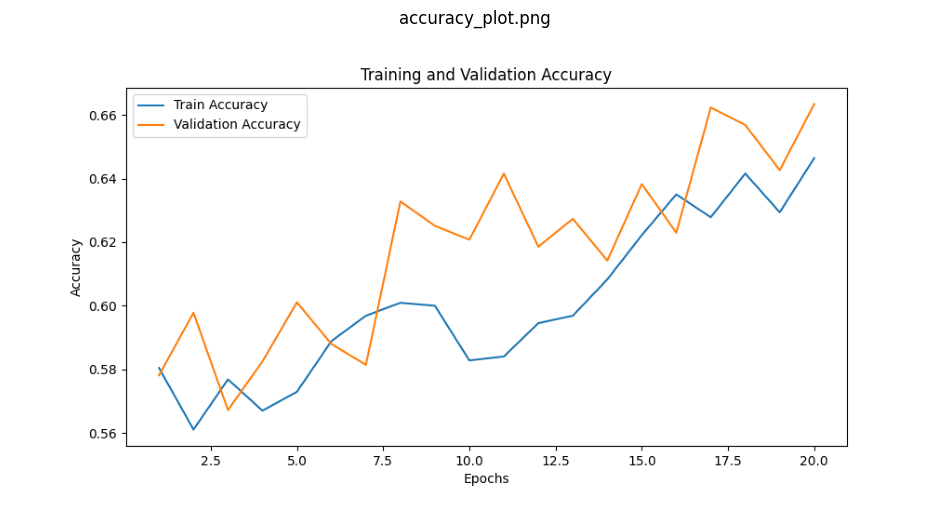

Displayed: accuracy_plot.png



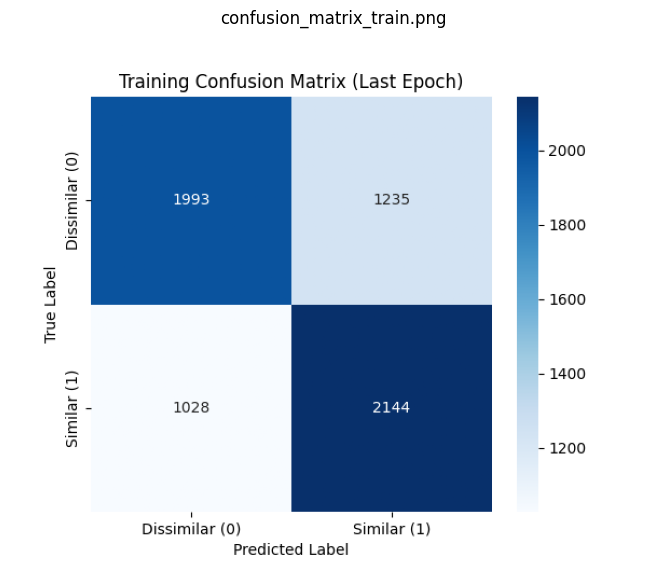

Displayed: confusion_matrix_train.png



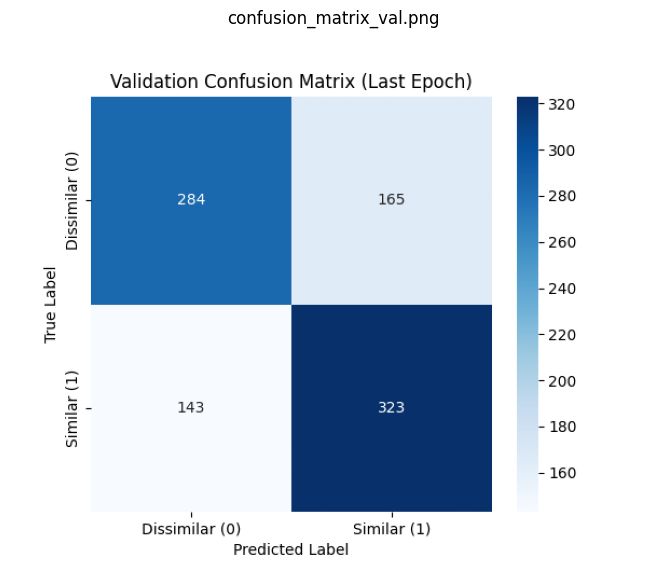

Displayed: confusion_matrix_val.png



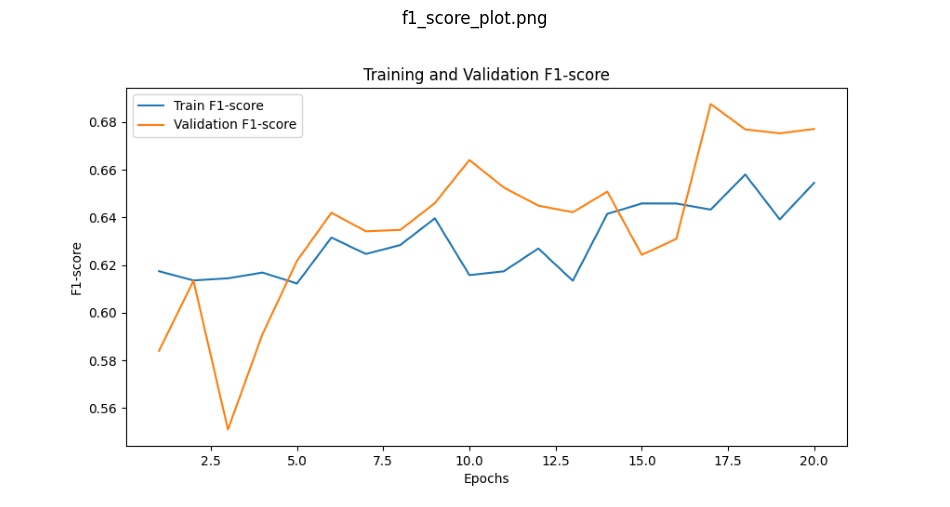

Displayed: f1_score_plot.png



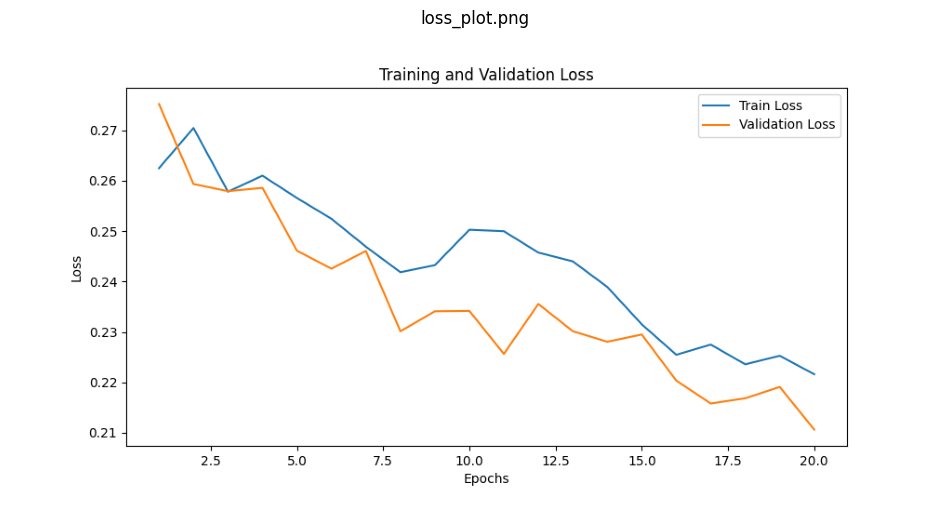

Displayed: loss_plot.png



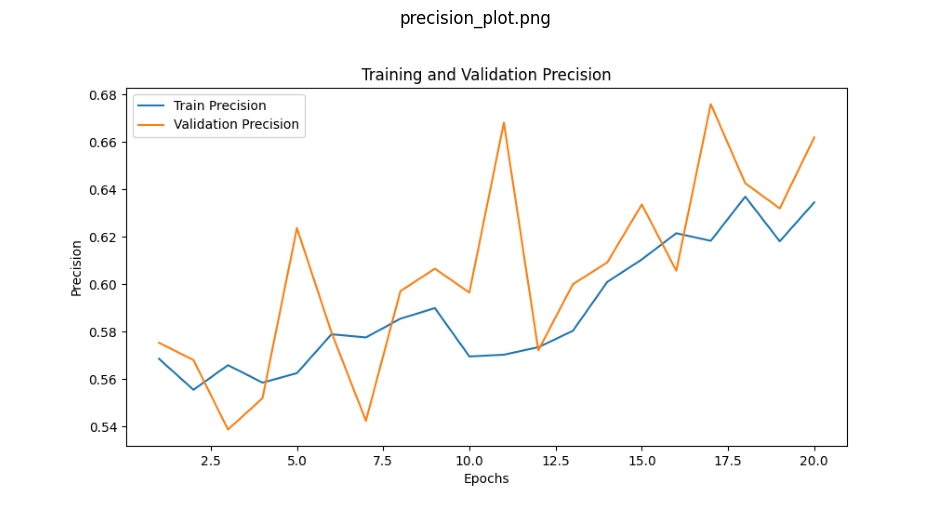

Displayed: precision_plot.png



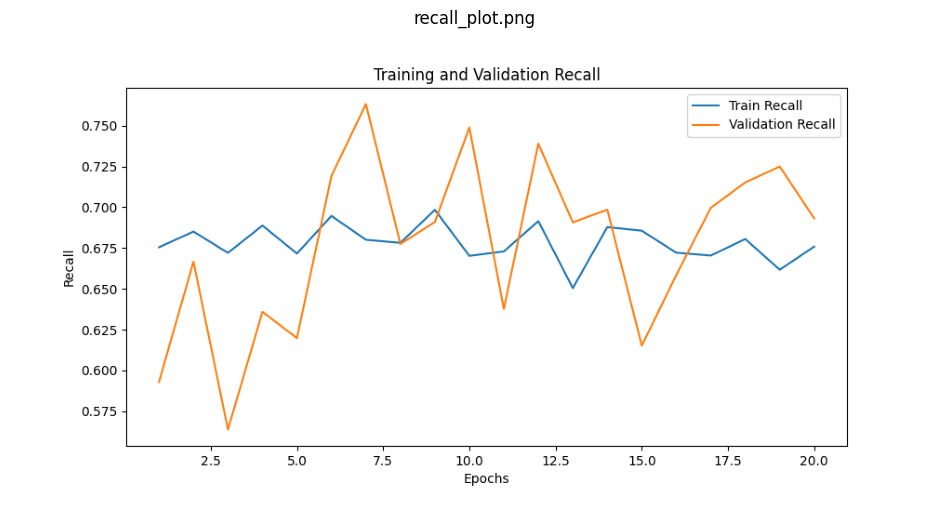

Displayed: recall_plot.png



In [12]:
if not plot_files:
    print(f"No plot images found in {plots_dir}. Ensure the training script ran correctly and saved plots.")
else:
    print(f"Found {len(plot_files)} plot(s) in {plots_dir}. Displaying them:\n")
    # Sort files for consistent order (optional)
    plot_files.sort()

    for plot_file_path in plot_files:
        try:
            img = mpimg.imread(plot_file_path) # Load the image
            plt.figure(figsize=(12, 7)) # Adjust figure size as needed
            plt.imshow(img)
            plt.title(os.path.basename(plot_file_path)) # Set title to filename
            plt.axis('off')  # Hide axes for image display
            plt.show()       # Display the image
            print(f"Displayed: {os.path.basename(plot_file_path)}\n")
        except Exception as e:
            print(f"Could not display {plot_file_path}. Error: {e}")